# Socc HAR - Verification and Evaluation

Run the following cells to...
 * view well-classified and poorly-classified samples sorted by dataset, class or score
 * re-annotate invalid annotation


Test Protokoll:
```
Je Experiment (Top Config aus Phase 2):
  Je Subset:
    Fehler pro Halbzeit ermitteln und z-Score berechnen
    Systematische Verschiebungen im UI kontrollieren falls z-Index > 3
    ggf neu exportieren

Je Experiment (Top Config aus Phase 2):
  Je Subset:
    33 Top Loss Samples verifizieren (höchste pro Klasse)

Sum up adjustments per period

Beste Modelle neu nachtrainieren

```

Insgesamt 3 (Modelle) x 3 (Subsets) x (33 + 10 bzw. 30) (Samples) = max. 447 Verifikationen

In [ ]:
3*2*10 + 3*1*30

150

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0. Setup

this step will...
  * fetch the source code
  * mount the video data to the VM
  * install the dependencies




👉 first of all you need to access the socc-har-toolkit repository. Therefore you need to upload your private SSH-Key. By running the following cell an upload promp will be shown. This is where your need to upload your SSH-Key!

In [ ]:
%cd /content
from google.colab import files
from pathlib import Path

uploaded = files.upload()

for filename in uploaded.keys():
  Path(filename).rename('id_rsa')
  assert Path('id_rsa').exists(), 'upload failed'

/content


Saving id_rsa to id_rsa


In [ ]:
%cd /content/
%env SSH_KEY=$filename
! chmod 400 $SSH_KEY
! GIT_SSH_COMMAND='ssh -i $SSH_KEY -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git clone git@gitlab.com:socc-har/socc-har-toolkit.git
%cd /content/socc-har-toolkit/

/content
env: SSH_KEY=id_rsa
Cloning into 'socc-har-toolkit'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 677 (delta 0), reused 0 (delta 0), pack-reused 671
Receiving objects: 100% (677/677), 8.40 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (441/441), done.
/content/socc-har-toolkit


In [ ]:
%cd /content/socc-har-toolkit/
! git reset --hard
! GIT_SSH_COMMAND='ssh -i ../id_rsa -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git fetch
! GIT_SSH_COMMAND='ssh -i ../id_rsa -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git checkout origin/master

/content/socc-har-toolkit
HEAD is now at fc9a1fb Removed grid from clipPlot
Note: checking out 'origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at fc9a1fb Removed grid from clipPlot


In [ ]:
assert Path('/content/socc-har-toolkit').exists(), 'cloning the repository failed'

👉 Now you need to mount your whole Drive Storage to the VM by following the upcoming dialog:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
assert Path('/content/drive').exists()

Mounted at /content/drive


⚠️ you can skip this step if you already did it **once**!

👉 you need to mount the video data stored in Google Drive to `socc-har-toolkit/data`.
Therefore you might got a public link to the content, which will navigate you to the `SOCC_HAR-32`-folder in Google Drive. Tap the folder and choose option `Add a shortcut to Drive` (like on the screenshot below) and link it to your personal Drive storage.

<style>img { width: 20px; }
</style>

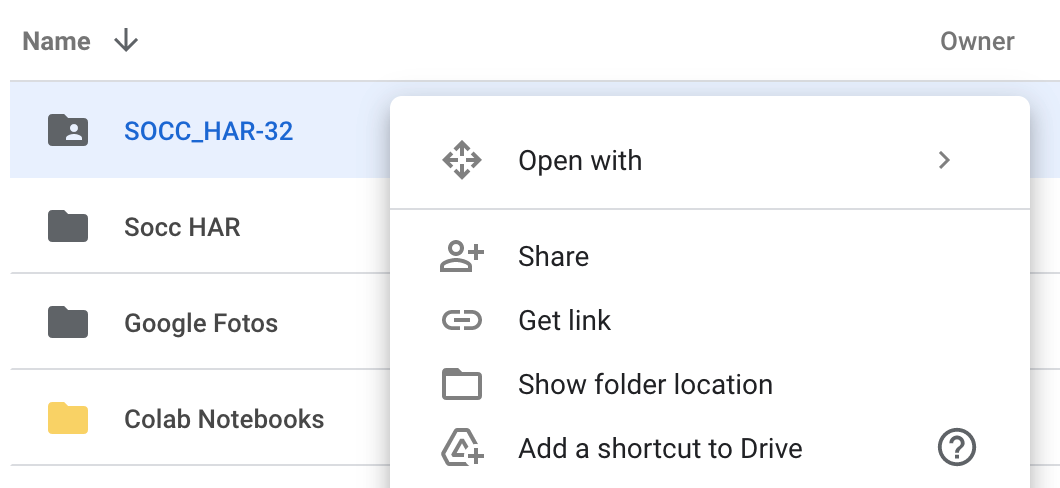

Your personal Drive Storage now is mounted to this VM, as you can see on the left-hand 'files'-tab in Colab under `/drive/MyDrive/` (see screenshot below)
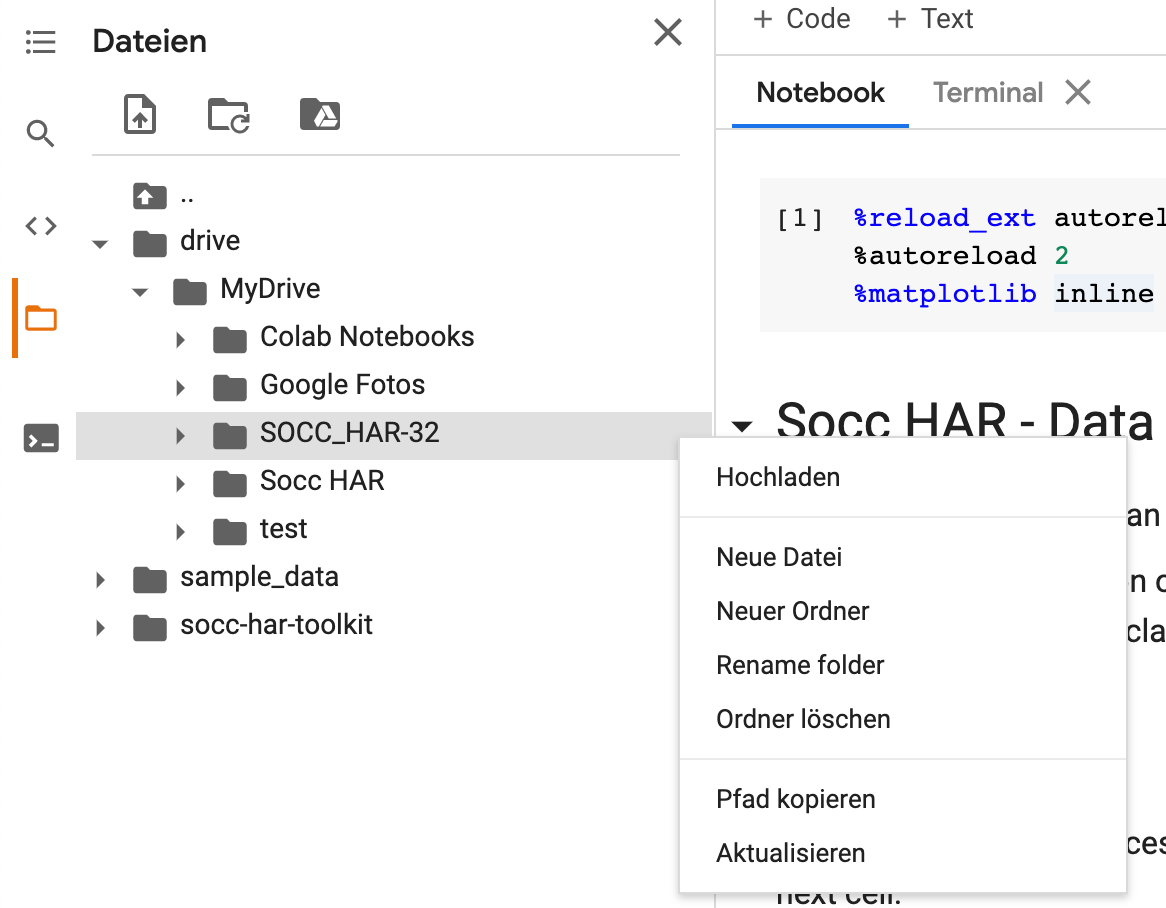

👉 Navigate to the SOCC_HAR-32-folder in the files tab (like in the screenshot above) and copy the path within the context menu shown in the above screenshot (`Pfad kopieren`). Then paste it into the following form under `data_mount_path` and run the cell

In [ ]:
import re

data_mount_path = "/content/drive/MyDrive/SOCC_HAR-32" #@param {type:"string"}

match = re.match(r'^\/content\/drive\/MyDrive\/.*SOCC_HAR-32\/?$', data_mount_path)
assert bool(match), 'path should start with /content/drive/MyDrive and ends with the folder name of SOCC_HAR-32'

In [ ]:
%env MOUNT_PATH=$data_mount_path
! mkdir /content/socc-har-toolkit/data
! ln -s $MOUNT_PATH/* /content/socc-har-toolkit/data

env: MOUNT_PATH=/content/drive/MyDrive/SOCC_HAR-32
mkdir: cannot create directory ‘/content/socc-har-toolkit/data’: File exists


Now the content of `SOCC_HAR-32` should also appear in `socc-har-toolkit/data`

In [ ]:
assert Path('/content/socc-har-toolkit/data/video/youtube').exists(), 'Your mount may exists, but is invalid'

finally install all needed dependencies:

In [ ]:
! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! pip install pytorch_lightning==1.1.1
! pip install av
! pip install matplotlib
! pip install git+https://gitlab.com/obuilds/public/pytube@ob-v1 # fork of pytube3
! pip install -U --no-cache-dir gdown --pre
! pip install comet_ml
! pip install celluloid
! pip install mmaction2==0.9.0
! pip install mmcv
! pip install -U scikit-learn

## 1. Pick an experiment

In [ ]:
%cd /content/socc-har-toolkit/

/content/socc-har-toolkit


In [ ]:
from socc_har.data import MediaDir, DatabaseHandle, DataModule
from socc_har.util.storage import Storage, StoredExperiment
from socc_har.train import TrainLogger
from socc_har.eval import EvaluationModule, ReportEvaluationModule, Transactions
from socc_har.eval.widgets import Plotter, Relabeler
import torch
import pandas as pd

In [ ]:
storage = Storage()
storage.widget()

In [ ]:
exp = StoredExperiment(storage.experiment_path)

pretrained_path = exp.get_checkpoints()
report_path = exp.get_report()
print(pretrained_path)
print(report_path)

download ckpt from narendorf/soccar-32-ph1/b72644fe5e324948a6c8c5bdadd06ea6
download report from narendorf/soccar-32-ph1/b72644fe5e324948a6c8c5bdadd06ea6
narendorf_soccar-32-ph1_b72644fe5e324948a6c8c5bdadd06ea6.ckpt
narendorf_soccar-32-ph1_b72644fe5e324948a6c8c5bdadd06ea6.csv


Hyperparameter:

In [ ]:
hparams = torch.load(pretrained_path, map_location=torch.device('cpu'))['hyper_parameters']
hparams

{'accumulate_grad_batches': 8,
 'batch_size': 8,
 'consensus': 'max',
 'epochs': 10,
 'fps': 8,
 'lr': [3e-06, 0.003],
 'mean': [0.37409, 0.44932, 0.30282],
 'name': 'irCSN_152',
 'num_frames': 32,
 'optim': 'adam',
 'pretrained_path': PosixPath('narendorf_soccar-32-pho_9a7c4b4803de43a7b15b3678cd32e3c0.ckpt'),
 'res': 224,
 'scheduler': 'cycle',
 'std': [0.01051, 0.01055, 0.01259],
 'trainable_groups': 4,
 'weight_decay': 0.0001}

In [ ]:
id = f'{hparams["name"]}_{hparams["num_frames"]}T_{hparams["fps"]}fps'
id

'irCSN_152_32T_8fps'

In [ ]:
best_epoch = torch.load(pretrained_path, map_location=torch.device('cpu'))['epoch']
f'best epoch = {best_epoch}'

'best epoch = 4'

## 2. Init Data Module


In [ ]:
#@title Storage
dataset = "socc-har-32-v0.3.2" #@param {type:"string"}
data_path = "./data"
out_path = "./data/out" #@param {type:"string"}
metadata_file = "./data/video_metadata/colab.pt" #@param {type:"string"}


In [ ]:
dm = DataModule(database=dataset,
                data_dir=data_path, out_dir=out_path,
                num_frames=hparams['num_frames'],
                res=hparams['res'], fps=hparams['fps'],
                max_train_samples_per_class=200,
                metadata_path=metadata_file)

db = dm.database

In [ ]:
dm.allow_critical = True

In [ ]:
dm.prepare_data(verbose=False)

found precomputed video metadata.


/content/socc-har-toolkit/socc_har/data/pre_processing.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_metadata[split]['video_pts'].append(torch.tensor(pts))



all videos found
video metadata saved to `data/out/video_metadata/202012-2023-2230.pth`


In [ ]:
dm.setup('fit')
dm.setup('test')

collecting samples



sample 6176/520575 clips
collecting samples



sample 1375/45333 clips
collecting samples



sample 2318/16580 clips


## 3. Initialize Logger

In [ ]:
#logger = TrainLogger('data', 'narendorf/soccar-32-ph2')
logger = TrainLogger.from_existing_run('narendorf/soccar-32-ph2/49be26751c9b4c25b08fff6e0fb5562b')

CometLogger will be initialized in online mode


## 4. Init Evaluator

In [ ]:
from matplotlib import pyplot as plt
df = pd.read_csv(report_path)

In [ ]:
eval = ReportEvaluationModule(out_path, dm, df, logger, ['png', 'eps'])
assert eval.integrity_check()
f'got report containing {eval.num_epochs} epochs and {eval.num_test_runs} tests (epoch={eval.last_test_epoch})'

'got report containing 10 epochs and 2 tests (epoch=4)'

In [ ]:
import torch
annos = torch.sum(torch.tensor([dm.stats[context].actions for context in ['train', 'val', 'test']]), dim=0).tolist()
distri = dict(zip(dm.classes, annos))
distri

{'50-50': 110,
 'backheel': 365,
 'badBehavior': 152,
 'block': 4978,
 'card': 707,
 'collected': 374,
 'corner': 1343,
 'cross': 3021,
 'deflected': 354,
 'dribbled': 3822,
 'finalWhistle': 305,
 'footShot': 2356,
 'foul': 3659,
 'freeKick': 2974,
 'goal': 542,
 'goalKick': 1230,
 'handball': 164,
 'headerShot': 462,
 'injury': 336,
 'interception': 2058,
 'kickOff': 466,
 'nutmeg': 150,
 'offside': 70,
 'overrun': 50,
 'penaltyKick': 39,
 'punch': 137,
 'refereeBallDrop': 31,
 'save': 1039,
 'shield': 129,
 'substitution': 836,
 'throughBall': 1129,
 'throwIn': 4103}

In [ ]:
import torch
annos = torch.sum(torch.tensor([dm.stats[context].actions for context in ['train', 'val', 'test']]), dim=0).tolist()
distri = dict(zip(dm.classes, annos))
distri

{'50-50': 110,
 'backheel': 365,
 'badBehavior': 153,
 'block': 4983,
 'card': 709,
 'collected': 374,
 'corner': 1342,
 'cross': 3027,
 'deflected': 357,
 'dribbled': 3824,
 'finalWhistle': 306,
 'footShot': 2359,
 'foul': 3660,
 'freeKick': 2974,
 'goal': 542,
 'goalKick': 1231,
 'handball': 164,
 'headerShot': 462,
 'injury': 334,
 'interception': 2058,
 'kickOff': 468,
 'nutmeg': 151,
 'offside': 71,
 'overrun': 50,
 'penaltyKick': 39,
 'punch': 138,
 'refereeBallDrop': 31,
 'save': 1041,
 'shield': 129,
 'substitution': 837,
 'throughBall': 1130,
 'throwIn': 4102}

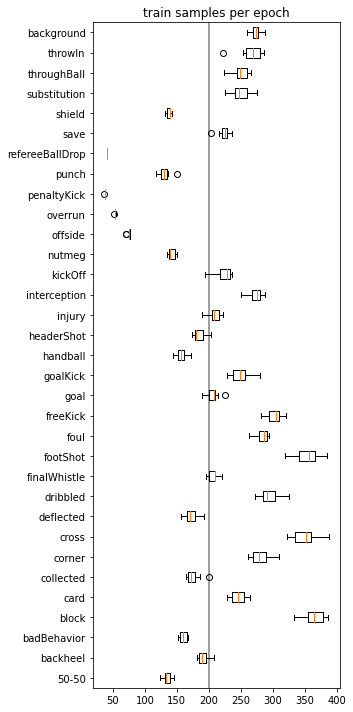

In [ ]:
fig = eval.train_samples_boxplot(True, False)
fig

In [ ]:
if eval.num_test_runs == 2:
    eval.get_metrics_by_consensus(True, False)

#### Loss by video/match

train:

In [ ]:
best_epoch = 9

In [ ]:
train_df = df[(df.subset == 'train') & (df.epoch == best_epoch)][['loss', 'key']].groupby('key')


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


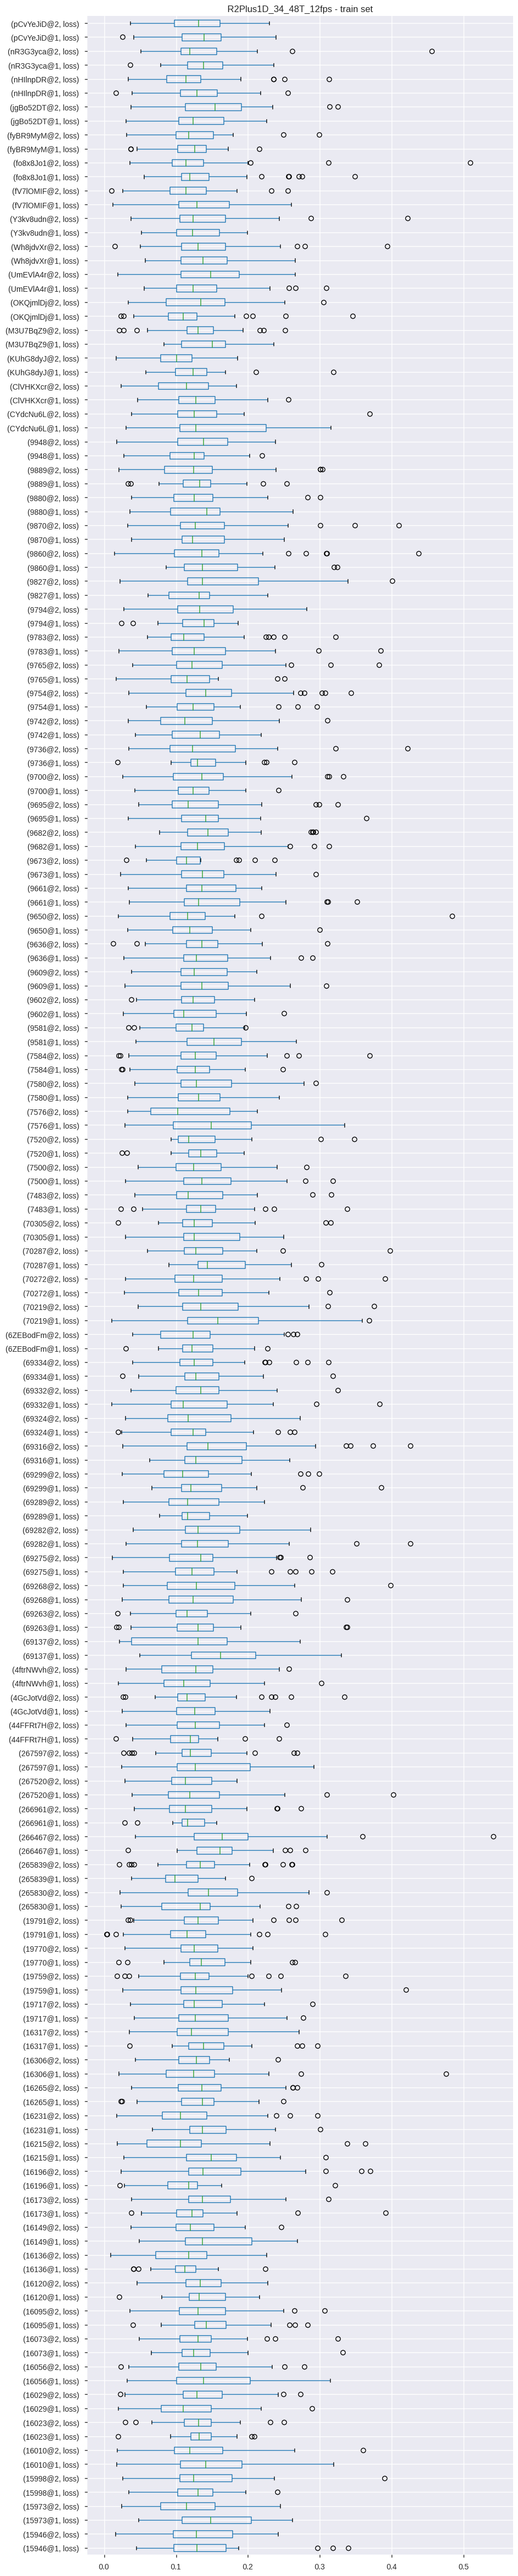

In [ ]:
fig, ax = plt.subplots(figsize=(10, len(train_df) // 3))
ax.set_title(f'{id} - train set')
train_df.boxplot(rot=0, subplots=False, ax=ax, vert=False)

In [ ]:
from scipy import stats
tmp_df = train_df.loss.median().sort_values(ascending=False)
outl = stats.zscore(tmp_df)
train_z_scores = pd.DataFrame({'period_id': tmp_df.index, 'median_loss': tmp_df.values, 'z-score': outl}).sort_values(by='median_loss')
train_z_scores

,period_id,median_loss,z-score
181,265839@1,0.098247,-2.573645
180,KUhG8dyJ@2,0.100632,-2.363053
179,7576@2,0.101531,-2.283678
178,16215@2,0.105813,-1.905570
177,16231@2,0.105852,-1.902118
...,...,...,...
4,jgBo52DT@2,0.154171,2.364278
3,70219@1,0.157572,2.664576
2,266467@1,0.160794,2.949093
1,69137@1,0.161629,3.022796


In [ ]:
logger.experiment.log_dataframe_profile(train_z_scores, name=f'z-scores_by_period_{id}_train_ep0', dataframe_format='csv')

COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=6c97805516764ccbad83832d35c1e025&experimentKey=49be26751c9b4c25b08fff6e0fb5562b',
  'assetId': '6c97805516764ccbad83832d35c1e025',
  'web': 'https://www.comet.ml/api/asset/download?assetId=6c97805516764ccbad83832d35c1e025&experimentKey=49be26751c9b4c25b08fff6e0fb5562b'},
 'profile': None}

In [ ]:
filename = f'{id}_train_loss_by_video'
fig.savefig(f'{filename}.eps', format='eps', bbox_inches='tight')
fig.savefig(f'{filename}.png', format='png', bbox_inches='tight')
with logger.experiment.context_manager("train"):
    logger.experiment.log_asset(f'{filename}.eps', metadata={'split': 'train', 'exp': storage.experiment_path})
    logger.experiment.log_asset(f'{filename}.png', metadata={'split': 'train', 'exp': storage.experiment_path})

val:

In [ ]:
val_df = df[(df.subset == 'val') & (df.epoch == best_epoch)][['loss', 'key']].groupby('key')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


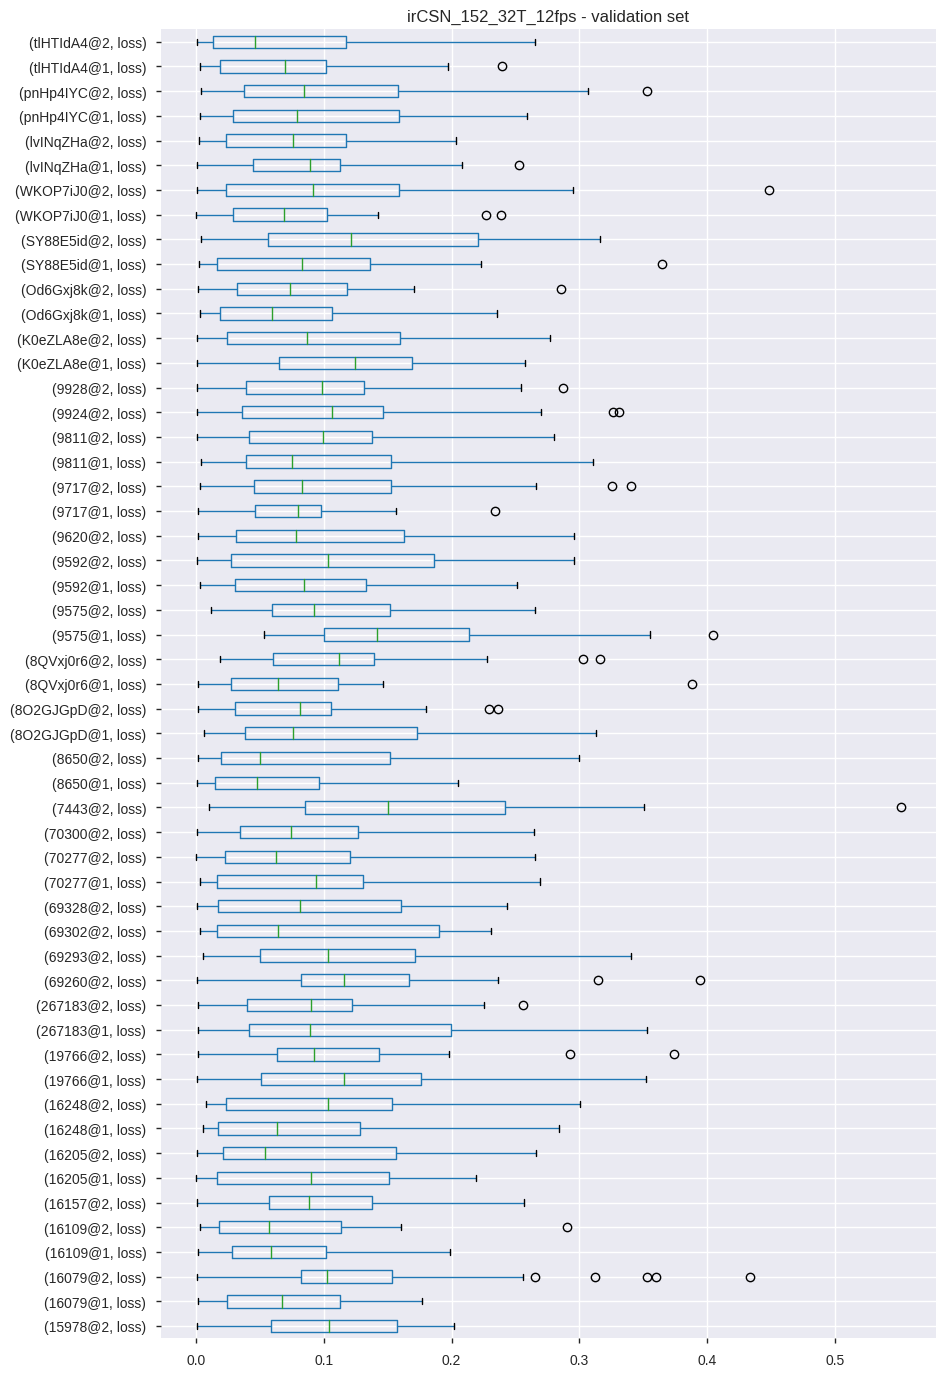

In [ ]:
fig, ax = plt.subplots(figsize=(10, len(val_df) // 3));
ax.set_title(f'{id} - validation set')
val_df.boxplot(rot=0, subplots=False, ax=ax, vert=False)

In [ ]:
val_df.loss.median().sort_values(ascending=False)


key
7443@2        0.150207
9575@1        0.141877
K0eZLA8e@1    0.124591
SY88E5id@2    0.121216
69260@2       0.116096
19766@1       0.115772
8QVxj0r6@2    0.111820
9924@2        0.106213
15978@2       0.103889
9592@2        0.103580
16248@2       0.103554
69293@2       0.103037
16079@2       0.102402
9811@2        0.099700
9928@2        0.098603
70277@1       0.094094
19766@2       0.092478
9575@2        0.092307
WKOP7iJ0@2    0.091423
267183@2      0.089780
16205@1       0.089700
lvINqZHa@1    0.089018
267183@1      0.088799
16157@2       0.088585
K0eZLA8e@2    0.087136
9592@1        0.084282
pnHp4IYC@2    0.084123
9717@2        0.082772
SY88E5id@1    0.082590
8O2GJGpD@2    0.081707
69328@2       0.080971
9717@1        0.079737
pnHp4IYC@1    0.079335
9620@2        0.078111
8O2GJGpD@1    0.076236
lvINqZHa@2    0.076060
9811@1        0.074778
70300@2       0.074500
Od6Gxj8k@2    0.073710
tlHTIdA4@1    0.069707
WKOP7iJ0@1    0.068696
16079@1       0.066884
8QVxj0r6@1    0.064345
69302@2

In [ ]:
from scipy import stats
tmp_df = val_df.loss.median().sort_values(ascending=False)
outl = stats.zscore(tmp_df)
train_z_scores = pd.DataFrame({'period_id': tmp_df.index, 'median_loss': tmp_df.values, 'z-score': outl}).sort_values(by='median_loss')
train_z_scores

,period_id,median_loss,z-score
52,tlHTIdA4@2,0.045800,-1.794969
51,8650@1,0.047527,-1.717457
50,8650@2,0.050198,-1.597651
49,16205@2,0.054295,-1.413808
48,16109@2,0.057169,-1.284891
47,16109@1,0.058642,-1.218770
46,Od6Gxj8k@1,0.059648,-1.173627
45,70277@2,0.062803,-1.032078
44,16248@1,0.063188,-1.014801
43,69302@2,0.064075,-0.975009


In [ ]:
logger.experiment.log_dataframe_profile(train_z_scores, name=f'z-scores_by_period_{id}_val', dataframe_format='csv')

COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=ca10bd9c93a94f468cdda0355265c5f9&experimentKey=49be26751c9b4c25b08fff6e0fb5562b',
  'assetId': 'ca10bd9c93a94f468cdda0355265c5f9',
  'web': 'https://www.comet.ml/api/asset/download?assetId=ca10bd9c93a94f468cdda0355265c5f9&experimentKey=49be26751c9b4c25b08fff6e0fb5562b'},
 'profile': None}

In [ ]:
filename = f'{id}_val_loss_by_video'
fig.savefig(f'{filename}.eps', format='eps', bbox_inches='tight')
fig.savefig(f'{filename}.png', format='png', bbox_inches='tight')
with logger.experiment.context_manager("train"):
    logger.experiment.log_asset(f'{filename}.eps', metadata={'split': 'val', 'exp': storage.experiment_path})
    logger.experiment.log_asset(f'{filename}.png', metadata={'split': 'val', 'exp': storage.experiment_path})

test:

In [ ]:
test_df = eval.test_df[['loss', 'key']].groupby('key')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


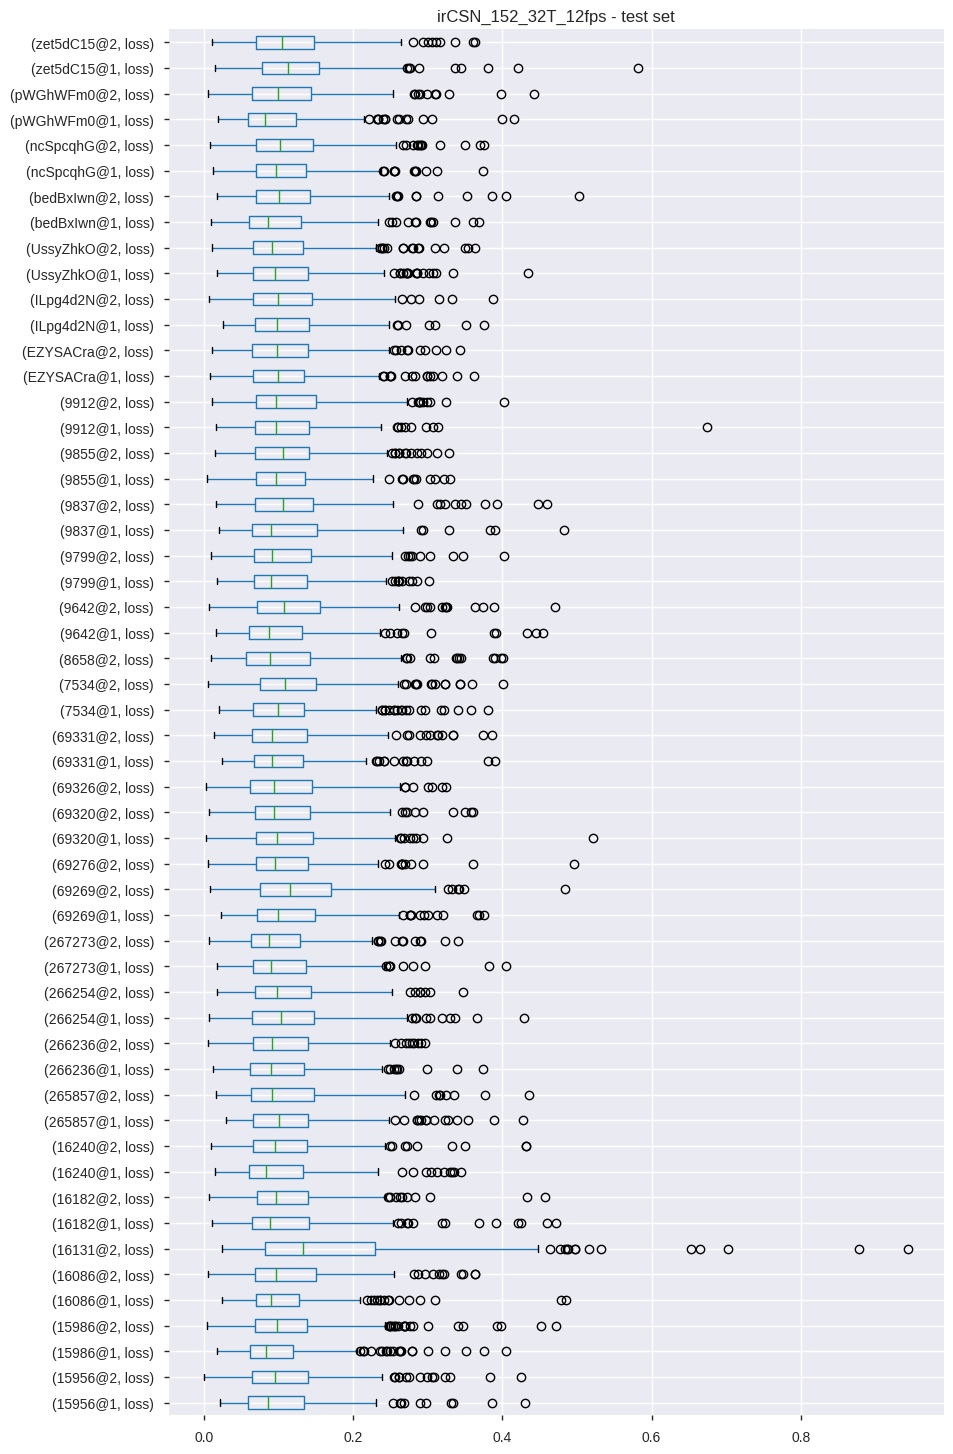

In [ ]:
fig, ax = plt.subplots(figsize=(10, len(test_df) // 3))
ax.set_title(f'{id} - test set')
test_df.boxplot(rot=0, subplots=False, ax=ax, vert=False)

In [ ]:
from scipy import stats
tmp_df = test_df.loss.median().sort_values(ascending=False)
outl = stats.zscore(tmp_df)
train_z_scores = pd.DataFrame({'period_id': tmp_df.index, 'median_loss': tmp_df.values, 'z-score': outl}).sort_values(by='median_loss')
train_z_scores

,period_id,median_loss,z-score
53,pWGhWFm0@1,0.081559,-1.718134
52,15986@1,0.083044,-1.547328
51,16240@1,0.083932,-1.445175
50,15956@1,0.085724,-1.238993
49,bedBxIwn@1,0.086249,-1.178616
48,267273@2,0.087120,-1.078442
47,9642@1,0.087804,-0.999717
46,16182@1,0.088861,-0.878118
45,8658@2,0.089055,-0.855827
44,16086@1,0.089544,-0.799607


In [ ]:
logger.experiment.log_dataframe_profile(train_z_scores, name=f'z-scores_by_period_{id}_test', dataframe_format='csv')

COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=b5a369ae02cf425f9387a3dfa3ce29f3&experimentKey=49be26751c9b4c25b08fff6e0fb5562b',
  'assetId': 'b5a369ae02cf425f9387a3dfa3ce29f3',
  'web': 'https://www.comet.ml/api/asset/download?assetId=b5a369ae02cf425f9387a3dfa3ce29f3&experimentKey=49be26751c9b4c25b08fff6e0fb5562b'},
 'profile': None}

In [ ]:
filename = f'{id}_test_loss_by_video'
fig.savefig(f'{filename}.eps', format='eps', bbox_inches='tight')
fig.savefig(f'{filename}.png', format='png', bbox_inches='tight')
with logger.experiment.context_manager("test"):
    logger.experiment.log_asset(f'{filename}.eps', metadata={'split': 'test', 'exp': storage.experiment_path})
    logger.experiment.log_asset(f'{filename}.png', metadata={'split': 'test', 'exp': storage.experiment_path})

## 5. Verify

* *optional*: clustering of classes
* *optional*: demo video


In [ ]:
from pathlib import Path
transactions = Transactions(f'transactions_{id}.csv', Path(out_path).joinpath('verifications'))

In [ ]:
assert dm.datasets['train'].allow_critical == dm.allow_critical

In [ ]:
label_tool = Relabeler(dm, logger, df, transactions, save_dir=Path(out_path))
label_tool

GridBox(children=(Box(children=(Dropdown(description='Dataset:', options=('train', 'val', 'test'), value='trai…

Error: '70219@2@2959.00' not present in train dataset
index 0 selected
index 0 selected
index 3 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 0 selected
index 2 selected
index 3 selected
index 1 selected
index 0 selected
index 0 selected
index 2 selected
index 1 selected
index 0 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 0 selected
index 1 selected
index 3 selected
index 2 selected
index 0 selected
index 0 selected
index 1 selected
index 0 selected
index 2 selected
index 0 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 1 selected
index 0 selected
index 2 selected
index 0 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 0 selected
index 1 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected
index 2 selected
index 1 sel

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/narendorf/soccar-32-ph2/49be26751c9b4c25b08fff6e0fb5562b
COMET INFO:   Uploads [count]:
COMET INFO:     asset [5] : 5
COMET INFO:     dataframe : 1
COMET INFO: -----------------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/narendorf/soccar-32-ph2/49be26751c9b4c25b08fff6e0fb5562b

COMET INFO: invalid metadata, expecting JSON-encodable object


saved to data/out/70287@2:2455.0-2459.0.gif
saved to data/out/70287@2:2455.0-2459.0.mp4


COMET INFO: invalid metadata, expecting JSON-encodable object


index 0 selected
index 0 selected
index 1 selected
index 0 selected
index 0 selected
index 0 selected
index 1 selected
index 2 selected
index 0 selected


COMET INFO: invalid metadata, expecting JSON-encodable object


saved to data/out/267183@2:6696.0-6700.0.gif
saved to data/out/267183@2:6696.0-6700.0.mp4


COMET INFO: invalid metadata, expecting JSON-encodable object


index 0 selected
index 0 selected
index 0 selected
index 1 selected
index 0 selected
index 0 selected
index 1 selected
index 0 selected
index 0 selected
index 0 selected
index 2 selected


In [ ]:
transactions.df

,period_id,url,src_label,src_segment,dest_label,dest_segment,operation
0,CYdcNu6L@2,https://raw.githubusercontent.com/statsbomb/op...,dribbled,"[1749.2, 1751.2]",dribbled,"[1749.5, 1751.0]",edit
1,CYdcNu6L@2,https://raw.githubusercontent.com/statsbomb/op...,card,"[1753, 1755]",card,"[1754.0, 1756.0]",edit
2,69268@2,https://raw.githubusercontent.com/statsbomb/op...,dribbled,"[4237.2, 4239.2]",None,None,delete
3,69268@2,https://raw.githubusercontent.com/statsbomb/op...,footShot,"[4238.3898, 4240.3898]",None,None,delete
4,69268@2,https://raw.githubusercontent.com/statsbomb/op...,save,"[4237.4, 4239.4]",None,None,delete
...,...,...,...,...,...,...,...
70,265857@2,None,None,None,save,"[4163.0, 4165.0]",add
71,16131@2,https://raw.githubusercontent.com/statsbomb/op...,footShot,"[5772.357416, 5774.357416]",footShot,"[5774.0, 5776.0]",edit
72,zet5dC15@1,https://raw.githubusercontent.com/statsbomb/op...,badBehavior,"[2889.4, 2891.4]",None,None,delete
73,zet5dC15@1,https://raw.githubusercontent.com/statsbomb/op...,card,"[2892, 2894]",None,None,delete


In [ ]:
transactions.path

'data/out/verifications/transactions_irCSN_152_32T_8fps.csv'

In [ ]:
logger.experiment.log_dataframe_profile(transactions.df, name=f'transactions_{id}', dataframe_format='csv')

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
Traceback (most recent call last):
TypeError: unhashable type: 'list'
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=196b9dd50ddf4963891dea7f0769a052&experimentKey=49be26751c9b4c25b08fff6e0fb5562b',
  'assetId': '196b9dd50ddf4963891dea7f0769a052',
  'web': 'https://www.comet.ml/api/asset/download?assetId=196b9dd50ddf4963891dea7f0769a052&experimentKey=49be26751c9b4c25b08fff6e0fb5562b'},
 'profile': None}

In [ ]:
transactions.apply(dm.database)

/content/socc-har-toolkit/socc_har/eval/database_transactions.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_left[self.df.period_id == period_id]
/content/socc-har-toolkit/socc_har/eval/database_transactions.py:111: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_left = df_left[~(self.df.period_id == period_id)]


In [ ]:
db_filename = Path(out_path).joinpath(f'socc-har-32-v0.3.3-{id}.json')
dm.database.save(db_filename)

In [ ]:
logger.experiment.log_asset(db_filename)

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=6c5f99b6627b4cb7a4c08f943995503c&experimentKey=49be26751c9b4c25b08fff6e0fb5562b',
 'assetId': '6c5f99b6627b4cb7a4c08f943995503c',
 'web': 'https://www.comet.ml/api/asset/download?assetId=6c5f99b6627b4cb7a4c08f943995503c&experimentKey=49be26751c9b4c25b08fff6e0fb5562b'}

In [ ]:
row = label_tool.indices[label_tool.index]
label_tool.dataset.info[row]

{'annotations': [{'deleted': False,
   'label': 'deflected',
   'segment': [3863.0, 3864.7],
   'source': {'segment': [3862, 3864]},
   'url': 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/9581.json#ea296c13-1154-4853-8dc2-2d763d8aa075',
   'verified': True},
  {'deleted': True,
   'label': 'kickOff',
   'segment': [3862.2, 3864.2],
   'url': 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/9581.json#1e9b5fb7-1a21-4c68-99f6-8cdb02bffa62',
   'verified': True},
  {'label': 'footShot',
   'segment': [3862.6517568, 3864.6517568],
   'url': 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/9581.json#98c1ed9e-4c37-4efc-ae99-9dbda60336a9'}],
 'critical': False,
 'end': 3864.28,
 'id': '9581@2@3863.00',
 'key': '9581@2',
 'path': 'data/video/youtube/NXeE97YRPnQ/360p.mp4',
 'start': 3863.0,
 'video': 'NXeE97YRPnQ'}

---



In [ ]:
plot_new = eval.get_sample_plot_by_report(subset, action_class)
plot_new.show('sample')

9837@2@4240.0 - collected, cross
test
4423
4423


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


In [ ]:
df = pd.DataFrame.from_dict(dm.database.database['69137@1']['annotations'])
df

,url,label,segment
0,https://raw.githubusercontent.com/statsbomb/op...,kickOff,"[188.237372, 190.237372]"
1,https://raw.githubusercontent.com/statsbomb/op...,throwIn,"[203.966501, 205.966501]"
2,https://raw.githubusercontent.com/statsbomb/op...,throwIn,"[233.9362, 235.9362]"
3,https://raw.githubusercontent.com/statsbomb/op...,throwIn,"[274.940494, 276.940494]"
4,https://raw.githubusercontent.com/statsbomb/op...,cross,"[278, 280.3157]"
...,...,...,...
132,https://raw.githubusercontent.com/statsbomb/op...,footShot,"[3104.555916, 3106.5559160000003]"
133,https://raw.githubusercontent.com/statsbomb/op...,block,"[3180.4, 3182.4]"
134,https://raw.githubusercontent.com/statsbomb/op...,throwIn,"[3229.232207, 3231.232207]"
135,https://raw.githubusercontent.com/statsbomb/op...,throwIn,"[3248.6279, 3250.6279]"
